In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [31]:

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [32]:

class CustomNN(nn.Module):
    def __init__(self, input_size, hidden_layers, neurons_per_layer, hidden_activation, output_size):
        super(CustomNN, self).__init__()
        
        # Dictionary untuk fungsi aktivasi
        self.activation_functions = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
            'leaky_relu': nn.LeakyReLU()
        }
        
        # Memastikan fungsi aktivasi valid
        if hidden_activation not in self.activation_functions:
            raise ValueError(f"Activation function must be one of {list(self.activation_functions.keys())}")
        
        self.activation = self.activation_functions[hidden_activation]
        
        # Membuat layers
        layers = []
        
        # Input layer ke hidden layer pertama
        layers.append(nn.Linear(input_size, neurons_per_layer[0]))
        layers.append(self.activation)
        
        # Hidden layers
        for i in range(hidden_layers - 1):
            layers.append(nn.Linear(neurons_per_layer[i], neurons_per_layer[i+1]))
            layers.append(self.activation)
        
        # Output layer
        layers.append(nn.Linear(neurons_per_layer[-1], output_size))
        layers.append(nn.LogSoftmax(dim=1))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)


In [ ]:

class NeuralNetworkCV:
    def __init__(self, hidden_layers, neurons_per_layer, hidden_activation, 
                 learning_rate, epochs, batch_size, n_splits=3):
        """
        Parameters:
        hidden_layers (int): Jumlah hidden layer
        neurons_per_layer (list): List berisi jumlah neuron untuk setiap hidden layer
        hidden_activation (str): Fungsi aktivasi untuk hidden layer
        learning_rate (float): Learning rate
        epochs (int): Jumlah epochs untuk training
        batch_size (int): Ukuran batch untuk training
        n_splits (int): Jumlah fold untuk cross validation
        """
        self.hidden_layers = hidden_layers
        self.neurons_per_layer = neurons_per_layer
        self.hidden_activation = hidden_activation
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.n_splits = n_splits
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.scaler = StandardScaler()
        
    def train_fold(self, model, train_loader, criterion, optimizer):
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = accuracy_score(true_labels, predictions)
        
        return epoch_loss, epoch_acc
    
    def validate_fold(self, model, val_loader, criterion):
        model.eval()
        running_loss = 0.0
        predictions = []
        true_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
        
        val_loss = running_loss / len(val_loader)
        val_acc = accuracy_score(true_labels, predictions)
        
        return val_loss, val_acc, predictions, true_labels
    
    def train_evaluate(self, X, y):
        """
        Training dan evaluasi model menggunakan stratified k-fold cross validation
        
        Parameters:
        X: Features
        y: Target labels
        """
        # Preprocessing
        X_scaled = self.scaler.fit_transform(X)
        
        # Inisialisasi k-fold
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        
        # Menyimpan hasil untuk setiap fold
        fold_results = []
        all_predictions = []
        all_true_labels = []
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y), 1):
            print(f"\nFold {fold}/{self.n_splits}")
            print("-" * 50)
            
            # Split data
            X_train_fold = X_scaled[train_idx]
            y_train_fold = y[train_idx]
            X_val_fold = X_scaled[val_idx]
            y_val_fold = y[val_idx]
            
            # Dataset dan DataLoader
            train_dataset = CustomDataset(X_train_fold, y_train_fold)
            val_dataset = CustomDataset(X_val_fold, y_val_fold)
            
            train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=self.batch_size)
            
            # Inisialisasi model
            model = CustomNN(
                input_size=X.shape[1],
                hidden_layers=self.hidden_layers,
                neurons_per_layer=self.neurons_per_layer,
                hidden_activation=self.hidden_activation,
                output_size=len(np.unique(y))
            ).to(self.device)
            
            # Loss dan optimizer
            criterion = nn.NLLLoss()
            optimizer = optim.Adam(model.parameters(), lr=self.learning_rate)
            
            # Training history untuk fold ini
            history = {
                'train_loss': [], 'train_acc': [],
                'val_loss': [], 'val_acc': []
            }
            
            # Training loop
            for epoch in range(self.epochs):
                # Training
                train_loss, train_acc = self.train_fold(model, train_loader, criterion, optimizer)
                
                # Validation
                val_loss, val_acc, fold_predictions, fold_true_labels = self.validate_fold(
                    model, val_loader, criterion
                )
                
                # Simpan history
                history['train_loss'].append(train_loss)
                history['train_acc'].append(train_acc)
                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)
                
                if (epoch + 1) % 10 == 0:
                    print(f"Epoch {epoch+1}/{self.epochs}")
                    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
                    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            
            # Simpan hasil fold
            fold_results.append({
                'fold': fold,
                'history': history,
                'final_val_acc': val_acc,
                'final_val_loss': val_loss
            })
            
            all_predictions.extend(fold_predictions)
            all_true_labels.extend(fold_true_labels)
            
        # Tampilkan hasil akhir
        self.print_final_results(fold_results, all_predictions, all_true_labels)
        self.plot_training_history(fold_results)
        
        return fold_results
    
    def print_final_results(self, fold_results, all_predictions, all_true_labels):
        """Menampilkan hasil akhir dari cross validation"""
        print("\nFinal Results")
        print("=" * 50)
        
        # Accuracy per fold
        accuracies = [fold['final_val_acc'] for fold in fold_results]
        print("\nAccuracy per fold:")
        for fold, acc in enumerate(accuracies, 1):
            print(f"Fold {fold}: {acc:.4f}")
        
        print(f"\nMean Accuracy: {np.mean(accuracies):.4f}")
        print(f"Std Accuracy: {np.std(accuracies):.4f}")
        
        # Classification report
        print("\nClassification Report:")
        print(classification_report(all_true_labels, all_predictions))
    
    def plot_training_history(self, fold_results):
        """Plot training history untuk semua fold"""
        plt.figure(figsize=(15, 5))
        
        # Plot accuracy
        plt.subplot(1, 2, 1)
        for fold in fold_results:
            plt.plot(fold['history']['train_acc'], label=f"Train Fold {fold['fold']}", alpha=0.3)
            plt.plot(fold['history']['val_acc'], label=f"Val Fold {fold['fold']}", alpha=0.3)
        plt.title('Model Accuracy Across Folds')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        # Plot loss
        plt.subplot(1, 2, 2)
        for fold in fold_results:
            plt.plot(fold['history']['train_loss'], label=f"Train Fold {fold['fold']}", alpha=0.3)
            plt.plot(fold['history']['val_loss'], label=f"Val Fold {fold['fold']}", alpha=0.3)
        plt.title('Model Loss Across Folds')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
    def predict(self, X_new, return_proba=False):
        """
        Melakukan prediksi untuk data baru menggunakan model terbaik
        
        Parameters:
        X_new: numpy array atau DataFrame dengan format yang sama dengan data training
        return_proba: bool, jika True mengembalikan probabilitas untuk setiap kelas
        
        Returns:
        predictions: array berisi prediksi kelas
        probabilities: array berisi probabilitas untuk setiap kelas (jika return_proba=True)
        """
        if self.final_model is None:
            raise ValueError("Model belum ditraining. Panggil train_evaluate terlebih dahulu.")
        
        # Preprocessing
        X_scaled = self.scaler.transform(X_new)
        
        # Convert ke tensor
        X_tensor = torch.FloatTensor(X_scaled).to(self.device)
        
        # Set model ke mode evaluasi
        self.final_model.eval()
        
        # Prediksi
        with torch.no_grad():
            outputs = self.final_model(X_tensor)
            probabilities = torch.exp(outputs)  # Convert dari log probabilities
            
            if return_proba:
                return (torch.max(outputs, 1)[1].cpu().numpy(), 
                        probabilities.cpu().numpy())
            else:
                return torch.max(outputs, 1)[1].cpu().numpy()
    
    def save_model(self, path):
        """
        Menyimpan model dan scaler
        
        Parameters:
        path: str, path untuk menyimpan model (tanpa ekstensi)
        """
        if self.final_model is None:
            raise ValueError("Model belum ditraining. Panggil train_evaluate terlebih dahulu.")
        
        # Simpan model state
        torch.save({
            'model_state_dict': self.final_model.state_dict(),
            'model_params': {
                'hidden_layers': self.hidden_layers,
                'neurons_per_layer': self.neurons_per_layer,
                'hidden_activation': self.hidden_activation,
                'input_size': next(self.final_model.parameters()).shape[1],
                'output_size': self.final_model.model[-2].out_features
            }
        }, f"{path}_model.pth")
        
        # Simpan scaler
        import joblib
        joblib.dump(self.scaler, f"{path}_scaler.pkl")
    
    @classmethod
    def load_model(cls, path):
        """
        Memuat model yang telah disimpan
        
        Parameters:
        path: str, path dimana model disimpan (tanpa ekstensi)
        
        Returns:
        NeuralNetworkCV instance dengan model yang telah dimuat
        """
        # Load model state dan parameters
        checkpoint = torch.load(f"{path}_model.pth")
        model_params = checkpoint['model_state_dict']
        params = checkpoint['model_params']
        
        # Load scaler
        import joblib
        scaler = joblib.load(f"{path}_scaler.pkl")
        
        # Buat instance baru
        instance = cls(
            hidden_layers=params['hidden_layers'],
            neurons_per_layer=params['neurons_per_layer'],
            hidden_activation=params['hidden_activation'],
            learning_rate=0.001,  # Default value
            epochs=1,  # Not needed for prediction
            batch_size=32  # Not needed for prediction
        )
        
        # Buat model dengan arsitektur yang sama
        instance.final_model = CustomNN(
            input_size=params['input_size'],
            hidden_layers=params['hidden_layers'],
            neurons_per_layer=params['neurons_per_layer'],
            hidden_activation=params['hidden_activation'],
            output_size=params['output_size']
        ).to(instance.device)
        
        # Load state dict
        instance.final_model.load_state_dict(model_params)
        instance.scaler = scaler
        
        return instance

    def predict_and_compare(self, X_new, y_true=None, return_proba=False):
        """
        Melakukan prediksi untuk data baru dan membandingkan dengan nilai sebenarnya jika tersedia
        
        Parameters:
        X_new: numpy array atau DataFrame - data untuk diprediksi
        y_true: numpy array atau Series - nilai target sebenarnya (opsional)
        return_proba: bool - jika True mengembalikan probabilitas untuk setiap kelas
        
        Returns:
        DataFrame berisi hasil prediksi dan perbandingan
        """
        if self.final_model is None:
            raise ValueError("Model belum ditraining. Panggil train_evaluate terlebih dahulu.")
        
        # Dapatkan prediksi
        if return_proba:
            predictions, probabilities = self.predict(X_new, return_proba=True)
        else:
            predictions = self.predict(X_new, return_proba=False)
        
        # Buat DataFrame hasil
        results_df = pd.DataFrame()
        
        # Tambahkan prediksi
        results_df['Predicted'] = predictions
        
        # Jika ada nilai sebenarnya
        if y_true is not None:
            results_df['Actual'] = y_true
            results_df['Is_Correct'] = results_df['Predicted'] == results_df['Actual']
            
            # Hitung statistik
            correct_count = results_df['Is_Correct'].sum()
            total_count = len(results_df)
            accuracy = correct_count / total_count
            
            # Tambahkan kolom probabilitas jika diminta
            if return_proba:
                for i in range(probabilities.shape[1]):
                    results_df[f'Probability_Class_{i}'] = probabilities[:, i]
            
            # Print ringkasan
            print("\nPrediction Summary")
            print("=" * 50)
            print(f"Total Predictions: {total_count}")
            print(f"Correct Predictions: {correct_count}")
            print(f"Accuracy: {accuracy:.4f}")
            
            # Tampilkan confusion matrix
            print("\nConfusion Matrix:")
            confusion_df = pd.crosstab(
                results_df['Actual'], 
                results_df['Predicted'], 
                margins=True
            )
            print(confusion_df)
            
            # Tampilkan report per kelas
            print("\nClassification Report:")
            print(classification_report(results_df['Actual'], results_df['Predicted']))
            
            # Tambahkan analisis kesalahan
            if len(results_df[~results_df['Is_Correct']]) > 0:
                print("\nMisclassified Samples:")
                misclassified = results_df[~results_df['Is_Correct']]
                print(misclassified.groupby(['Actual', 'Predicted']).size().unstack(fill_value=0))
        
        return results_df


# Contoh penggunaan:


In [34]:

df=pd.read_csv("C:/Users/luxha/Python data 101/Notebooks/diabetes_012_health_indicators_BRFSS2015.csv")


In [35]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler

In [36]:
df['Diabetes_012'].value_counts()

Diabetes_012
0.0    213703
2.0     35346
1.0      4631
Name: count, dtype: int64

In [37]:
X = df.drop(columns='Diabetes_012')
y = df['Diabetes_012']


In [38]:
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X, y= undersampler.fit_resample(X, y)

In [45]:
y.value_counts()

Diabetes_012
0.0    4631
1.0    4631
2.0    4631
Name: count, dtype: int64

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [40]:
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
y_test_np  = np.array(y_test)
X_test_np  = np.array(X_test)


Fold 1/2
--------------------------------------------------
Epoch 10/1000
Train Loss: 0.9287, Train Acc: 0.5427
Val Loss: 0.9680, Val Acc: 0.5170
Epoch 20/1000
Train Loss: 0.8822, Train Acc: 0.5712
Val Loss: 0.9854, Val Acc: 0.5060
Epoch 30/1000
Train Loss: 0.8448, Train Acc: 0.5859
Val Loss: 1.0965, Val Acc: 0.5046
Epoch 40/1000
Train Loss: 0.8031, Train Acc: 0.6172
Val Loss: 1.1418, Val Acc: 0.4834
Epoch 50/1000
Train Loss: 0.7704, Train Acc: 0.6316
Val Loss: 1.3468, Val Acc: 0.4920
Epoch 60/1000
Train Loss: 0.7466, Train Acc: 0.6414
Val Loss: 1.2754, Val Acc: 0.4756
Epoch 70/1000
Train Loss: 0.7310, Train Acc: 0.6574
Val Loss: 1.4316, Val Acc: 0.4855
Epoch 80/1000
Train Loss: 0.7115, Train Acc: 0.6624
Val Loss: 1.4764, Val Acc: 0.4763
Epoch 90/1000
Train Loss: 0.6954, Train Acc: 0.6721
Val Loss: 1.6889, Val Acc: 0.4859
Epoch 100/1000
Train Loss: 0.6876, Train Acc: 0.6898
Val Loss: 1.6575, Val Acc: 0.4733
Epoch 110/1000
Train Loss: 0.6650, Train Acc: 0.6946
Val Loss: 1.6622, Val Acc

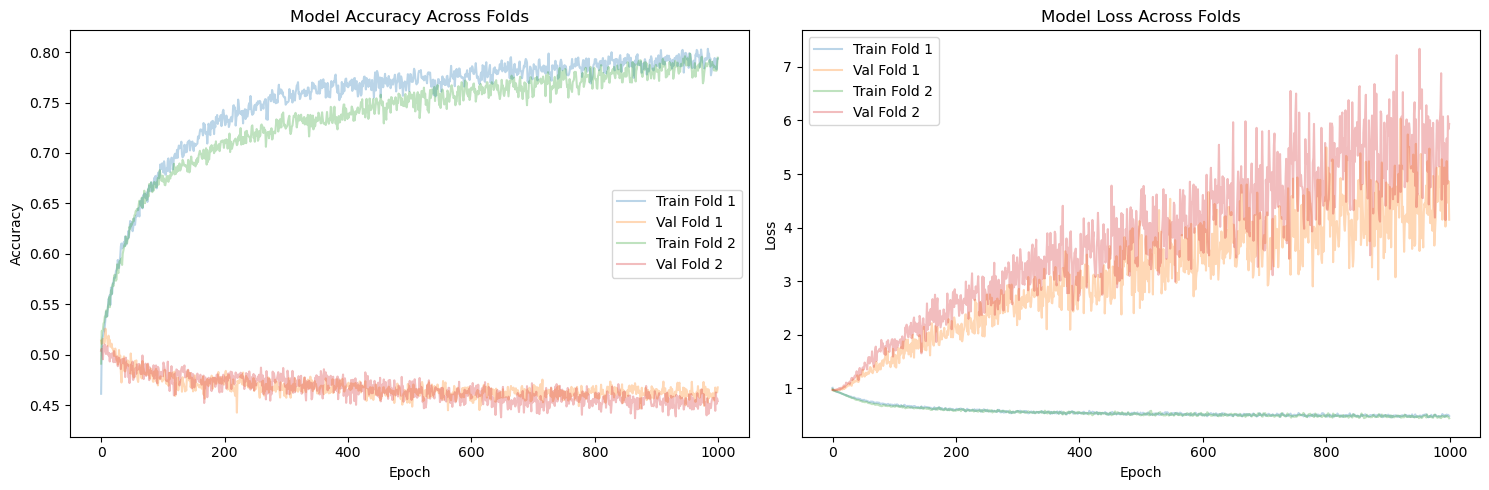

In [48]:

hidden_layers = 4
neurons_per_layer = [64, 32,16,8]  # Jumlah neuron untuk setiap hidden layer
hidden_activation = 'relu'
learning_rate = 0.01
epochs = 1000
batch_size = 32

# Buat instance model
nn_cv = NeuralNetworkCV(
    hidden_layers=hidden_layers,
    neurons_per_layer=neurons_per_layer,
    hidden_activation=hidden_activation,
    learning_rate=learning_rate,
    epochs=epochs,
    batch_size=batch_size,
    n_splits=2
)

# Training dan evaluasi dengan cross validation
results = nn_cv.train_evaluate(X_train_np, y_train_np)


In [42]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Prediksi dan bandingkan dengan nilai sebenarnya
# Untuk data test
results_df = nn_cv.predict_and_compare(X_test, y_test, return_proba=True)

# Plot confusion matrix
nn_cv.plot_confusion_matrix(results_df['Actual'], results_df['Predicted'])

# Lihat beberapa baris pertama hasil prediksi
print("\nSample Predictions:")
print(results_df.head())

# Untuk data baru tanpa label
new_data_results = nn_cv.predict_and_compare(X_new)
print("\nNew Data Predictions:")
print(new_data_results.head())

# Menyimpan hasil ke CSV

In [43]:
# # Prediksi dengan probabilitas
# predictions, probabilities = nn_cv.predict(X_test, return_proba=True)

# Menyimpan model
nn_cv.save_model('C:/Users/luxha/Python data 101')


AttributeError: 'NeuralNetworkCV' object has no attribute 'save_model'

In [ ]:

# # Memuat model
# loaded_model = NeuralNetworkCV.load_model('path/to/save/model')
# predictions = loaded_model.predict(X_new)